In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.optimize as scopt

plt.ion()
plt.rcParams['figure.figsize'] = 8, 6

In [9]:
# solve the system dy/dt = f(y, t)
def sir_demography(y, t, beta, gamma, birth, death):
    Si, Ii, Ri = tuple(y)
    # the simple endemic equilibrium is when Ii = 0
    # endemic equilibrium is characterized by the fraction of
    # susceptibles in the population being the inverse of R0
    # with R0 = beta / (death + gamma)
    # the endemic equilibrium is stable if R0 > 1,
    # otherwise the disease-free equilibrium state is stable
    
    assert birth == death
    f0 = -beta*Si*Ii + birth - death*Si
    f1 = beta*Si*Ii - gamma*Ii - death*Ii
    f2 = gamma*Ii - death*Ri
    return [f0, f1, f2]

def sir_infection_mortality(y, t, beta, gamma, birth, death, mortality):
    Si, Ii, Ri = tuple(y)
    assert birth == death
    assert mortality < 1.0
    f0 = -beta*Si*Ii + birth - death*Si
    f1 = beta*Si*Ii - gamma*Ii - death*Ii - mortality/(1.0 - mortality)*(death + gamma)*Ii
    # f1 = beta*Si*Ii - (gamma + death)/(1.0 - mortality)*Ii
    f2 = gamma*Ii - death*Ri
    return [f0, f1, f2]

In [20]:
def model_infections(
    model, # model to use
    y0, # initial condition vector
    *parameters, # model parameters
    days = 90, # number of years to compute
    resolution = 1000, # resolution of numerical integration
    closed = True, # assume closed (constant) population
    plot_susceptible = False, # plot susceptible
    plot_infected = False, # plot infected
    plot_recovered = False, # plot recovered
):
    assert len(parameters) >= 4
    beta, gamma, birth, death = parameters[:4]
    R0 = beta / (gamma + death)
    t = np.linspace(0, days, days * resolution)
    sol = scint.odeint(model, y0, t, args=parameters)
    S = sol[:, 0]
    I = sol[:, 1]
    R = sol[:, 2]
    if closed:
        assert np.allclose(sol.sum(axis=1), 1.)
    # print(sol.sum(axis=1))
    
    if any([plot_susceptible, plot_infected, plot_recovered]):
        fig, ax = plt.subplots()
        if plot_susceptible:
            ax.plot(t, S, label='Susceptible')
        if plot_infected:
            ax.plot(t, I, label='Infected')
        if plot_recovered:
            ax.plot(t, R, label='Recovered')
        if days > 365:
            plt.xlabel('year')
            years = np.arange(0, (days//365) + 1)
            plt.xticks(365 * years, years)
        else:
            plt.xlabel('day')
        plt.ylabel('population')
        plt.title('SIR for an endemic (beta=%.2f, gamma=%.2f, birth=%.2f, death=%.2f)' % (
            beta, gamma, birth, death
        ))
        plt.legend(loc=0)
        plt.show()
    return R0, S, I, R, t

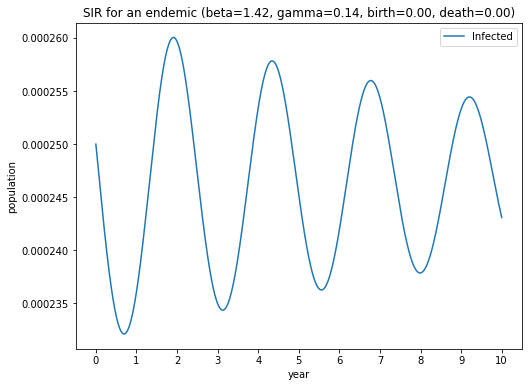

R0 9.969871268145713


In [21]:
# initial conditions
I0 = 2.5*1e-4  # initial number of infected people
S0 = 0.1 # initial number of susceptible people
R0 = 1.0 - (I0 + S0) # initial number of recovered people
y0 = [S0, I0, R0] # initial condition vector

# beta, gamma, death = 520.0, 1.0/(7.0/365.0), 1.0/(70.0)
beta, gamma, death = 520.0/365.0, 1.0/(7.0), 1.0/(70.0*365.0)
# print("beta", beta, "gamma", (1.0/gamma)*365.0, "death", 1.0/death)
# print("beta", beta, "gamma", gamma, "death", death)
birth = death
R0, S, I, R, t = model_infections(
    sir_demography,
    y0, beta, gamma, death, birth,
    days=10 * 365, resolution=1_00, closed=True, plot_infected=True
)
print("R0", R0)

expected frequency f=0.00 (T=887.10)
dominant frequency f=0.00 (T=912.50)


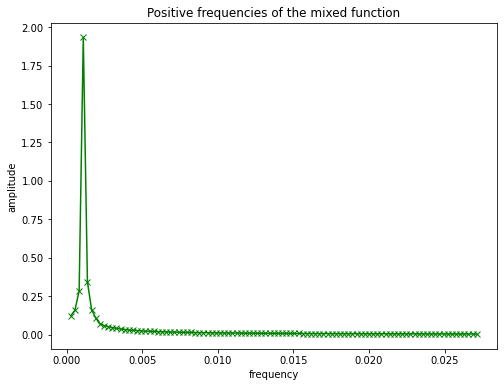

In [22]:
import scipy.fft

fourier = scipy.fft.rfft(I)
freqs = scipy.fft.rfftfreq(len(I), d=t[1]-t[0])
assert freqs.shape == fourier.shape

A = 1.0/(death*(R0 - 1.0)) # mean age at infection
G = 1.0/(death + gamma) # period of host infectivity
T = 2*np.pi*np.sqrt(A*G)
print("expected frequency f=%.2f (T=%.2f)" % (1/T, T))

amps = np.abs(fourier)
dominant_freq = freqs[1:][np.argmax(amps[1:])]
print("dominant frequency f=%.2f (T=%.2f)" % (dominant_freq, 1/dominant_freq))

fig, ax = plt.subplots()
i_min = 1
i_max = 100
ax.plot(freqs[i_min:i_max], amps[i_min:i_max], marker="x", c='green')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title("Positive frequencies of the mixed function")
plt.show()

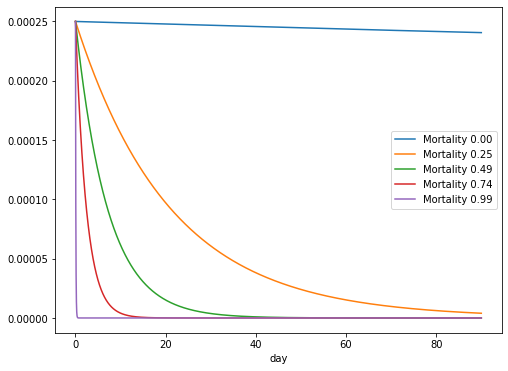

In [26]:
fig, ax = plt.subplots()
plt.xlabel('day')
plt.ylabel('infected')
# plt.title('SIR for an endemic (beta=%.2f, gamma=%.2f, birth=%.2f, death=%.2f)' % (
#    beta, gamma, birth, death
# ))
for mortality in np.linspace(0, 0.99, 5):
    R0, S, I, R, t = model_infections(
        sir_infection_mortality,
        y0, beta, gamma, death, death, mortality,
        days=90, resolution=1_000, closed=False
    )
    ax.plot(t, I, label='Mortality %.2f' % mortality)
plt.legend(loc=0)
plt.show()

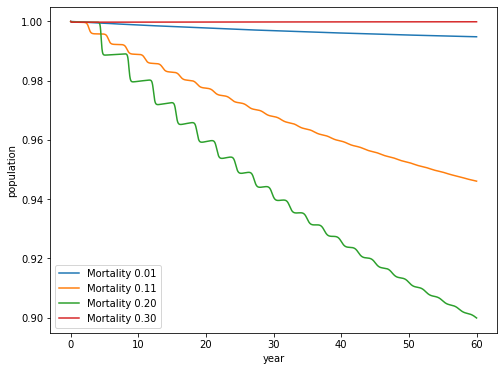

In [47]:
fig, ax = plt.subplots()
plt.xlabel('year')
plt.ylabel('population')
years = 60
for mortality in np.linspace(0.01, 0.3, 4):
    R0, S, I, R, t = model_infections(
        sir_infection_mortality,
        y0, beta, gamma, death, death, mortality,
        days=years * 365, resolution=4_00, closed=False
    )
    ax.plot(t, S+I+R, label='Mortality %.2f' % mortality)
years = np.arange(0, years+1, 10)
plt.xticks(365 * years, years)
plt.legend(loc=0)
plt.show()